In [1]:
import pandas as pd
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.tsa.stattools
import statsmodels.graphics.tsaplots
from datetime import datetime, timedelta
from copy import deepcopy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Global imports
plt.style.use('seaborn')

def input_data_processing(Filepath):
    # 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
    data = pd.read_csv(Filepath)
    columns_name = data.columns.tolist()
    if columns_name != ['DATE', 'CLOSE']:
        data.rename(columns={columns_name[0]:'DATE', columns_name[1]:'CLOSE'}, inplace = True)
    data['DATE'] = pd.to_datetime(data['DATE'])
    return data

def draw_acf_pacf(ts, lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Moving Average Graph
def draw_trend(timeseries, size=12):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()
    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
'''
　 Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root.
'''
def testStationarity(time_series):
    dftest = statsmodels.tsa.stattools.adfuller(time_series)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

def proper_model(data_ts):
    init_bic = sys.maxsize
    init_p = 0
    init_q = 0
    init_properModel = None
    maxLag_p = int(len(data_ts)/10) + 1
    maxLag_q = int(len(data_ts)/10) + 1
    for p in np.arange(maxLag_p):
        for q in np.arange(maxLag_q):
            try:
                model = statsmodels.tsa.arima_model.ARMA(data_ts, order=(p, q), freq = 'D')
                results_ARMA = model.fit(disp=-1, method='css')
                bic = results_ARMA.bic
                if bic < init_bic:
                    init_p = p
                    init_q = q
                    init_properModel = results_ARMA
                    init_bic = bic
            except:
                continue
    return init_properModel, init_p, init_q

def diff_to_stationary(ts):
    if(testStationarity(ts)['p-value'] <= 0.05):
        return ts,0
    else:
        ts_diff = ts.diff(1).dropna()
        num = 1
        while(testStationarity(ts_diff)['p-value'] > 0.05):
            ts_diff = ts_diff.diff(1).dropna()
            num += 1
        return ts_diff, num

In [3]:
def arima_predict(data, predict_day, training_days = timedelta(days = 30)):
    # 缺失日期，线性插值处理
    helper = pd.DataFrame({'DATE': pd.date_range(data['DATE'].min(), data['DATE'].max())})
    data = pd.merge(data, helper, on='DATE', how='outer').sort_values('DATE')
    data['CLOSE'] = data['CLOSE'].interpolate(method='linear')
    data.set_index(pd.to_datetime(data.DATE), inplace=True) # set the index to be the DATE
    data.sort_index(inplace=True)  # sort the dataframe by the newly created datetime index
    
    data = data[data.index < predict_day]
    data = data[data.index >= predict_day - training_days]
    ts = data['CLOSE']
    ts.index = pd.to_datetime(data.index)
    # Required ts.values>0
    ts = np.log(ts)
    
    # from statsmodels.tsa.seasonal import seasonal_decompose
    # decomposition = seasonal_decompose(ts, model="additive")
    # trend = decomposition.trend
    # seasonal = decomposition.seasonal
    # residual = decomposition.resid
    # trend.plot()
    # seasonal.plot()
    # residual.plot()
    
    ts_diff, num_of_diff = diff_to_stationary(ts)

    #draw_acf_pacf(ts_diff)

    inf_lst = proper_model(ts_diff)
    end_time = predict_day - timedelta(days = 1)
    day1 = predict_day
#     day2 = predict_day + timedelta(days = 1)
#     day3 = predict_day + timedelta(days = 2)
#     day4 = predict_day + timedelta(days = 3)
#     day5 = predict_day + timedelta(days = 4)
#     predict_ts = inf_lst[0].predict(day1, day5, dynamic=True)
    predict_ts = inf_lst[0].predict(day1, dynamic=True)
    
    for i in range(num_of_diff):
        if(num_of_diff - i - 1 != 0):
            predict_ts[day1] = predict_ts[day1] + ts.diff(num_of_diff - i)[end_time]
        else:
            predict_ts[day1] = predict_ts[day1] + ts[end_time]
#         predict_ts[day2] = predict_ts[day2] + predict_ts[day1]
#         predict_ts[day3] = predict_ts[day3] + predict_ts[day2]
#         predict_ts[day4] = predict_ts[day4] + predict_ts[day3]
#         predict_ts[day5] = predict_ts[day5] + predict_ts[day4]

    predict_ts = np.exp(predict_ts)

    return predict_ts

In [4]:
if __name__ == '__main__':
    data = input_data_processing('Stock_id_7.csv')
    data_copy = deepcopy(data)
    #创建一个空的Series
    predict_data = pd.Series()
    for idx in range(50, len(data), 1):
        try:
            predict_result = arima_predict(data.loc[0:idx], data.loc[idx+1, 'DATE'], timedelta(days = 40))
            predict_data = predict_data.append(predict_result)
        except:
            continue

d:\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
d:\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
d:\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInver

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInvers

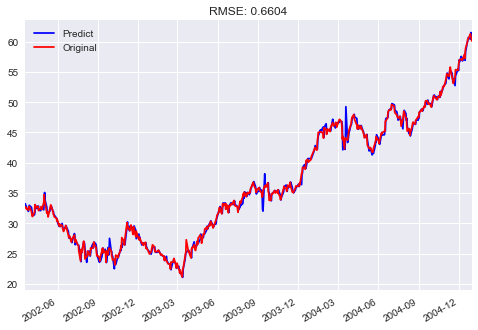

In [5]:
def Df_to_Series(data):
    data.set_index(pd.to_datetime(data.DATE), inplace=True) # set the index to be the DATE
    data.sort_index(inplace=True)  # sort the dataframe by the newly created datetime index
    ts = data['CLOSE']             # create the pd.Series Object
    return ts

# Plotting the predict result using time series
# Root Mean Square Error is the standard deviation of the residuals (prediction errors).
# Lower values of RMSE indicate better fit.
# 进行判别时，需要剔除“非预测”数据的影响
ts = Df_to_Series(data_copy)
ts = ts[predict_data.index]
plt.figure(facecolor='white')
predict_data.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_data-ts)**2)/ts.size))
plt.show()